## Load libraries

In [1]:
# Add root project directory to path
import sys
sys.path.append("../")

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
from collections import defaultdict

from diffnet.dataset_loader import *
from diffnet.diffnet import *

## Check status

In [2]:
!nvidia-smi

Thu May 26 15:39:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:09:00.0 Off |                  N/A |
| 35%   37C    P8    21W / 260W |     15MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:0A:00.0 Off |                  N/A |
| 35%   

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="1"

tf.config.list_physical_devices("GPU")

# allocate as small memory as possible
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

## Load input file

In [5]:
FEATURE_INPUT_FILES = ["../data/features/pormake_geo+gridhist_50.txt", "../data/features/tobacco_geo+gridhist_50.txt"]
LABEL_INPUT_FILES = ["../data/labels/pormake_adsorption_isotherm_low_pressure_ch4.txt", "../data/labels/tobacco_adsorption_isotherm_low_pressure_ch4.txt"]

f_input_df = pd.read_csv(FEATURE_INPUT_FILES[0], sep="\s+", index_col=0)
l_input_df = pd.read_csv(LABEL_INPUT_FILES[0], sep="\s+", index_col=0, header=None)

for i in range(len(FEATURE_INPUT_FILES)-1):
    idx = i+1
    
    try:
        f_df = pd.read_csv(FEATURE_INPUT_FILES[idx], sep="\s+", index_col=0)
        l_df = pd.read_csv(LABEL_INPUT_FILES[idx], sep="\s+", index_col=0, header=None)

        f_input_df = pd.concat([f_input_df, f_df])
        l_input_df = pd.concat([l_input_df, l_df])
    
    except:
        continue
    
f_input_df = f_input_df.sample(frac=1)

In [6]:
## normalize geometric features
geo_cols = f_input_df.columns[:5]
geo_df = f_input_df[:][geo_cols]

max_v = [100, 100, 4000, 10000, 1]
    
f_input_df[:][geo_cols] = f_input_df[:][geo_cols] / max_v

# only for geo only
#f_input_df = f_input_df[:][geo_cols]

In [7]:
f_input_df.head()

,LCD,PLD,Vol_ASA,Grav_ASA,Void_fraction,0.0,0.02,0.04,0.06,0.08,...,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96,0.98
MOF,,,,,,,,,,,,,,,,,,,,,
mof_12725,0.360546,0.261599,0.258368,0.613569,0.79194,0.0,0.0,0.0,0.0,0.0,...,0.001043,0.000850,0.000722,0.000866,0.000802,0.000754,0.000562,0.000481,0.000626,0.195443
mof_11507,0.295180,0.219512,0.279410,0.599600,0.77160,0.0,0.0,0.0,0.0,0.0,...,0.000884,0.000769,0.000846,0.000756,0.000782,0.000833,0.000679,0.000679,0.000743,0.213238
mof_1043,0.319098,0.306980,0.378277,0.401385,0.62936,0.0,0.0,0.0,0.0,0.0,...,0.001134,0.000916,0.001308,0.001221,0.001177,0.001221,0.000872,0.000741,0.001003,0.345805
mof_302,0.112304,0.095249,0.507835,0.315924,0.47578,0.0,0.0,0.0,0.0,0.0,...,0.001385,0.001500,0.002078,0.001500,0.001500,0.002078,0.002193,0.001039,0.001847,0.492729
zfz+N332+E162,0.183625,0.151469,0.352303,0.395687,0.67692,0.0,0.0,0.0,0.0,0.0,...,0.001220,0.001064,0.001064,0.000939,0.001064,0.000907,0.000845,0.001095,0.000751,0.304368


In [8]:
## normalize labels
# 1: 1bar, 2: 2bar, 3: 5.8bar, 4: 10bar, 5: 15bar, 6: 20bar, 7: 30bar, 8:40 bar, 9: 50bar, 10: 60bar, 11:65bar, 12: 80bar, 13: 90bar, 14: 100bar
# (low p) 1 : 0.25bar, 2:, 0.5bar, 3 : 0.75bar / else is not meaningful
l_data = l_input_df[:][1]

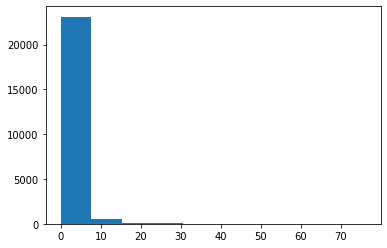

In [9]:
plt.hist(l_data)
plt.show()

In [10]:
print(max(l_data))
print(min(l_data))

76.138405
0.0


In [11]:
max_v = 100
min_v = 0

In [12]:
## normalize data
l_data = (l_data - min_v ) / (max_v - min_v)

In [13]:
f_data = f_input_df.copy()

In [14]:
# shuffle input data
data_name = []

for name in l_data.index:
    if name in f_data.index:
        data_name.append(name)
        
np.random.shuffle(data_name)

In [15]:
n_train = int(0.72*len(data_name))
n_val = int(0.08*len(data_name))
n_test = len(data_name) - n_train - n_val

train_data = data_name[:n_train]
val_data = data_name[n_train:n_train+n_val]
test_data = data_name[-n_test:]

print("train data : {}, val data : {}, test data : {}".format(len(train_data), len(val_data), len(test_data)))

train data : 17166, val data : 1907, test data : 4769


### load dataloader

In [16]:
dataloader = DataLoader()

In [17]:
train_f_data, train_l_data = dataloader.arrange_data(f_data, l_data, train_data)
val_f_data, val_l_data = dataloader.arrange_data(f_data, l_data, val_data)
#test_f_data, test_l_data = dataloader.arrange_data(f_data, l_data, test_data)

In [18]:
# load data from input file
### REPEAT 설정 추가!!
train_dataset = dataloader.make_dataset(np.array(train_f_data), np.array(train_l_data), 
                                        batch_size=1000, repeat=True, shuffle=True, buffer_size=len(train_l_data))

val_dataset = dataloader.make_dataset(np.array(val_f_data), np.array(val_l_data), 
                                       batch_size=len(val_l_data), repeat=True, shuffle=False)


train_dataset_iter = iter(train_dataset)
val_dataset_iter = iter(val_dataset)

## DiffNET run

In [19]:
# Hyperparameters
n_steps = 200000
lr = 0.00001
optimizer = tf.optimizers.Adam(lr=lr)
step = 0

prefix = "../checkpoint/source_geo+gridhist/"
save_dir = "test"
# min rmse
min_loss = 1e30
min_step = 0

In [20]:
if not os.path.exists(prefix+save_dir):
    os.makedirs(prefix+save_dir)

In [21]:
with open("{}/train_data.pickle".format(prefix+save_dir), "wb") as f:
    pickle.dump(train_data, f)
f.close()

with open("{}/val_data.pickle".format(prefix+save_dir), "wb") as f:
    pickle.dump(val_data, f)
f.close()

with open("{}/test_data.pickle".format(prefix+save_dir), "wb") as g:
    pickle.dump(test_data, g)
g.close()

with open("{}/training_time.txt".format(prefix+save_dir), "w") as h:
    h.write("Step\tTime duration\tloss(mse)\n")
h.close()

In [22]:
# load DiffNET model
diffnet = DiffNET(training=True, input_size=(len(f_data.columns),), transfer=False)
diffnet.initialize_weights()
diffnet.summary()

Model: "diff_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  28672     
_________________________________________________________________
dense_1 (Dense)              multiple                  65664     
_________________________________________________________________
dense_2 (Dense)              multiple                  129       
Total params: 94,465
Trainable params: 94,465
Non-trainable params: 0
_________________________________________________________________


In [23]:
# necessary functions for machine learning model

def cal_mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true-y_pred))
    return loss

@tf.function
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = cal_mse(y_true=y, y_pred=y_pred)
        
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return y_pred, loss

In [24]:
train_loss_list = []
train_step_idx = []
val_loss_list = []
val_step_idx = []

In [25]:
start = time.time()
while step < n_steps+1:
    if step == 0:
        step += 1
        continue
    
    x, y = next(train_dataset_iter)
    y_pred, loss = train_step(diffnet, x, y, optimizer)
    
    train_loss_list.append(loss)
    train_step_idx.append(step)
    #print(loss)
    
    if step % 1000 == 0:
        val_x, val_y = next(val_dataset_iter)
        val_y_pred = diffnet(val_x, training=False)

        val_loss = cal_mse(y_true=val_y, y_pred=val_y_pred)

        print("[{:d}] Loss Val: {:7.4f}, MIN MSE ({:d}): {:.4f}".format(step, val_loss, min_step, min_loss))

        val_loss_list.append(val_loss)
        val_step_idx.append(step)
        
        if val_loss < min_loss:
            min_step = step
            print("NEW MIN LOSS : %7.4f" % val_loss)
            diffnet.save_weights("{}/diffnet-{}-min.h5".format(prefix+save_dir, save_dir))
            min_loss = val_loss
            
            now = time.time()
            with open("{}/training_time.txt".format(prefix+save_dir), "a") as h:
                h.write("{step}\t{time}\t{loss}\n".format(step=min_step, time=now-start, loss=min_loss))
            
            h.close()
            
    if step % 20000 == 0:
        diffnet.save_weights("{}/diffnet-{}-{}.h5".format(prefix+save_dir, save_dir, step))
        
    step+=1

[1000] Loss Val:  0.0004, MIN MSE (0): 1000000000000000019884624838656.0000
NEW MIN LOSS :  0.0004


KeyboardInterrupt: 

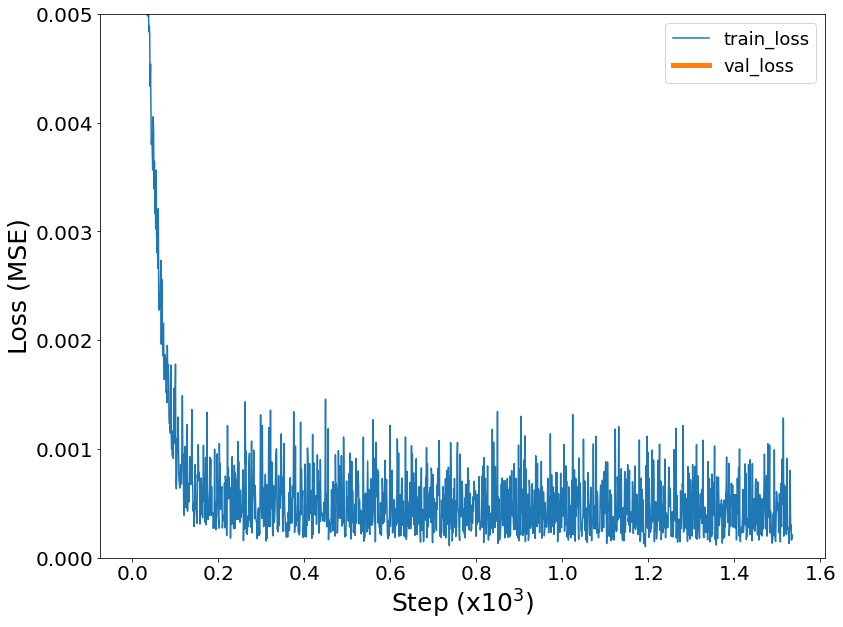

In [26]:
plt.figure(figsize=(13,10))
plt.plot(np.array(train_step_idx) / 1e3, train_loss_list, label="train_loss")
plt.plot(np.array(val_step_idx) / 1e3, val_loss_list, label="val_loss", lw=5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.ylim(0, 0.005)
plt.xlabel("Step (x$10^{3}$)", fontsize=25)
plt.ylabel("Loss (MSE)", fontsize=25)
plt.savefig("{}/loss_plot.png".format(prefix+save_dir), bbox_inches="tight")
plt.show()

## Test cell

In [27]:
from sklearn.metrics import r2_score

In [28]:
diffnet = DiffNET(input_size=(len(f_data.columns),), transfer=True)
diffnet.initialize_weights()
diffnet.load_weights("{}/diffnet-{}-min.h5".format(prefix+save_dir, save_dir))

In [29]:
test_f_data, test_l_data = dataloader.arrange_data(f_data, l_data, test_data)

In [30]:
test_dataset = dataloader.make_dataset(np.array(test_f_data), np.array(test_l_data),
                           batch_size=len(test_l_data), shuffle=False, repeat=False)

test_dataset = test_dataset.batch(len(test_l_data))

In [32]:
test_y_pred = []
test_y_true = []

for x, y in test_dataset:
    _y = diffnet(x, training=False)
    test_y_pred += _y.numpy().reshape(-1).tolist()
    test_y_true += y.numpy().reshape(-1).tolist()
    
test_y_pred = np.array(test_y_pred)
test_y_true = np.array(test_y_true)

In [33]:
y_true_ = test_y_true * (max_v - min_v) + min_v
y_pred_ = test_y_pred * (max_v - min_v) + min_v

In [34]:
# in log scale (only for KH)
test_mse = cal_mse(y_true=y_true_, y_pred=y_pred_).numpy().item()
test_r2score = r2_score(y_true_, y_pred_)

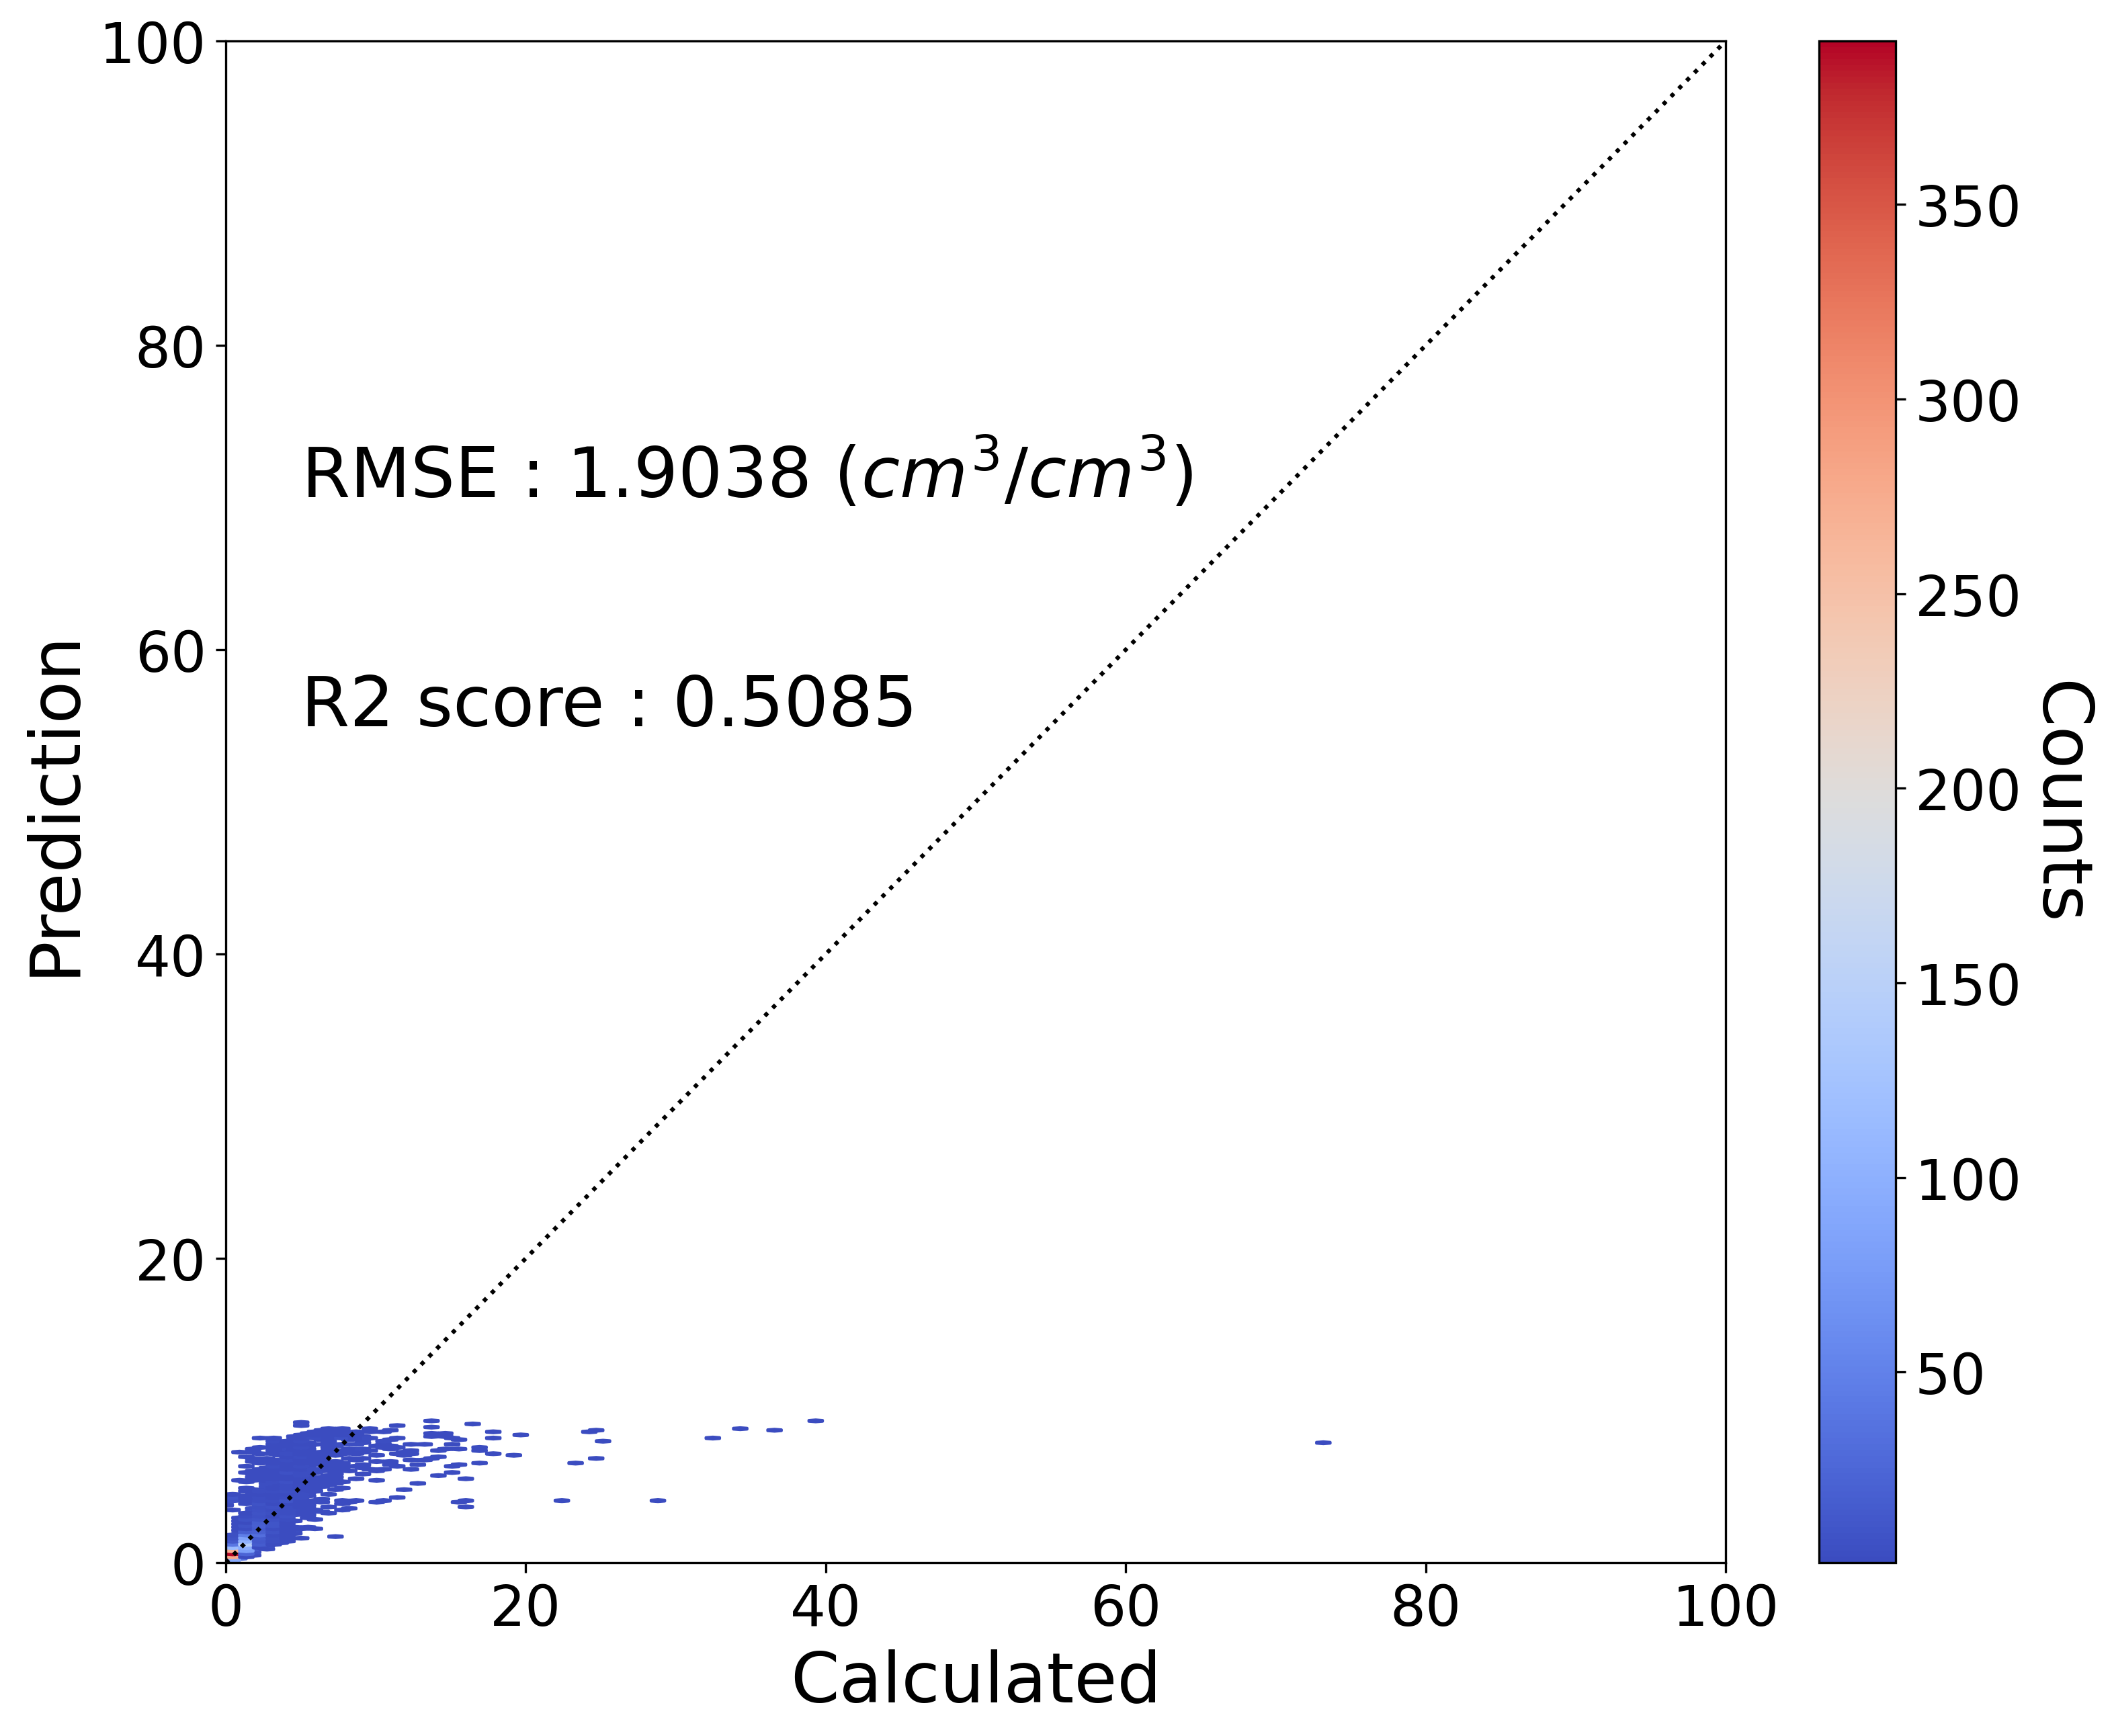

In [35]:
plt.figure(figsize=(12,10), dpi=300)
hb = plt.hexbin(y_true_, y_pred_, gridsize=80, cmap="coolwarm", mincnt=1)
plt.plot([0, max_v], [0, max_v], color="black", ls=":")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, max_v])
plt.ylim([0, max_v])
plt.xlabel("Calculated", fontsize=25)
plt.ylabel("Prediction", fontsize=25)
#plt.xscale("log")
#plt.yscale("log")
plt.text(5, max_v - 30, "RMSE : {:.4f} ($cm^3$/$cm^3$)".format(np.sqrt(test_mse)), fontsize=25)
plt.text(5, max_v - 45, "R2 score : {:.4f}".format(test_r2score), fontsize=25)
cb = plt.colorbar(hb)
cb.set_label("Counts", fontsize=25, rotation=270, labelpad=25)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
plt.savefig("{}/testset_hexbin.png".format(prefix+save_dir), bbox_inches="tight")
plt.show()